In [1]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
from torch import nn
import numpy as np

class Linear_CL(nn.Linear):
    def __init__(self,n):
        super().__init__(n,n,bias=False)
        self.n=n
        
    def log_abs_det(self):
        return torch.log(torch.abs(torch.det(self.weight)))
    
    def g(self,z):
        return self.forward(z), (self.log_abs_det())*torch.ones((z.shape[0]))
        

In [3]:
import torch
from torch import nn
import numpy as np

class L1(nn.Linear):
    def __init__(self,n):
        super().__init__(n*(n-1)//2,1,bias=False)
        self.n=n
        self.mask2d=torch.zeros((n*(n-1) // 2),dtype=int)
        for i in range(1,n):
            for j in range(i):
                self.mask2d[i*(i-1)//2+j]=i*n+j
        self.d_ind=[(n+1)*k for k in range(n)]
        self.ones=torch.ones((n))
    
    def anti_flatten(self):
        n=self.n
        L=torch.zeros((n**2)).to(device)
        L[self.mask2d]=self.weight.to(device)
        L[self.d_ind]=self.ones
        L=torch.reshape(L,(n,n)).to(device)
        return L        
            
    def log_abs_det(self):
        return 0
    
    def forward(self,x):
        Lwt=torch.t(self.anti_flatten())
        return torch.matmul(x,Lwt)
    
    def g(self,z):
        return self.forward(z), torch.zeros((z.shape[0]))
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D
    

In [4]:
import torch
from torch import nn
import numpy as np

class D(nn.Linear):
    def __init__(self,n):
        super().__init__(n,1,bias=False)
        self.n=n
        self.d_ind=[(n+1)*k for k in range(n)]
    
    def anti_flatten(self):
        n=self.n
        D=torch.zeros((n**2)).to(device)
        D[self.d_ind]=self.weight.to(device)
        D=torch.reshape(D,(n,n)).to(device)
        return D        
            
    def log_abs_det(self):
        ABS=torch.abs(self.weight)
        l=torch.log(ABS)
        lad=torch.sum(l)
        return lad
    
    def forward(self,x):
        D=self.anti_flatten()
        return torch.matmul(x,D)
    
    def g(self,z):
        lad=self.log_abs_det()
        return self.forward(z), lad * torch.ones((z.shape[0]))
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D
    

In [5]:
m=L1(10)
#print(m.anti_flatten())
d=D(10)
#print(d.anti_flatten())

In [6]:
z=torch.rand((10,10))
x, lad= m.g(z)
x, lad= d.g(z)
print(x, lad)

tensor([[ 0.0746, -0.0933,  0.0117, -0.1131,  0.1047, -0.0332,  0.0792, -0.2627,
          0.0493,  0.0783],
        [ 0.0750, -0.0875,  0.0006, -0.0833,  0.0055, -0.1197,  0.0851, -0.2436,
          0.0204,  0.1890],
        [ 0.0323, -0.1165,  0.0767, -0.2221,  0.0609, -0.1830,  0.0783, -0.0787,
          0.0010,  0.0179],
        [ 0.0320, -0.1088,  0.0016, -0.2157,  0.0841, -0.1873,  0.0332, -0.1772,
          0.0155,  0.0217],
        [ 0.1233, -0.1639,  0.1090, -0.0819,  0.1413, -0.1988,  0.0267, -0.1159,
          0.0077,  0.1147],
        [ 0.1110, -0.1642,  0.0098, -0.1949,  0.0147, -0.0869,  0.0376, -0.2151,
          0.1059,  0.2148],
        [ 0.1238, -0.0825,  0.0203, -0.0175,  0.1279, -0.0307,  0.0835, -0.2521,
          0.0237,  0.2739],
        [ 0.0247, -0.1978,  0.1533, -0.1773,  0.0748, -0.1591,  0.0668, -0.1809,
          0.0332,  0.0917],
        [ 0.0189, -0.0234,  0.0584, -0.1419,  0.0888, -0.0806,  0.0044, -0.1699,
          0.0192,  0.0369],
        [ 0.1305, -

In [7]:
import torch
from torch import nn
import numpy as np

class L(nn.Linear):
    def __init__(self,n):
        super().__init__(n*(n+1)//2,1,bias=False)
        self.n=n
        self.diag_mask=torch.tensor([ (k+1) * (k+2) // 2 - 1 for k in range(n)])
        self.mask2d=torch.zeros((n*(n+1) // 2),dtype=int)
        for i in range(n):
            for j in range(i+1):
                self.mask2d[i*(i+1)//2+j]=i*n+j
    
    def anti_flatten(self):
        n=self.n
        L=torch.zeros((n**2)).to(device)
        L[self.mask2d]=self.weight.to(device) 
        L=torch.reshape(L,(n,n)).to(device)
        return L        
            
    def log_abs_det(self):
        diag=self.weight[0][self.diag_mask]
        la=torch.log(torch.abs(diag))
        lad=torch.sum(la)
        return lad
    
    def forward(self,x):
        Lwt=torch.t(self.anti_flatten())
        return torch.matmul(x,Lwt)
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D
    

In [8]:
from NFandist import get_O, get_A
from NFconstants import N_nod, Beta
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=torch.t(O)
print(Ot.requires_grad)

A=(torch.tensor(get_A(N_nod,Beta)).float()).to(device)
I=(torch.eye(N_nod)).to(device)

False


In [9]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], conv_flows = [], ort=False):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.conv_flows = conv_flows

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor) -> torch.Tensor:
        
        #x, sum_log_abs_det = z, torch.ones(z.size(0)).to(z.device)
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x=torch.matmul(x,Ot.to(x.device))
        
        #x=x*a    
        
        for flow in reversed(self.conv_flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    

In [17]:
def configure_flows():  # n_flows=8,...,12
    flows=[]
    
    #flows.append(Linear_CL(N_nod))
    flows.append(D(N_nod))
    flows.append(L1(N_nod))

    
    flows = nn.ModuleList(flows)
    return flows 

In [18]:
from NFconstants import N_nod, Beta , N_traj
from NFandist import get_A, get_C
A=(torch.tensor(get_A(N_nod,Beta)).float()).to(device)
I=(torch.eye(N_nod)).to(device)
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)


In [19]:
class Cheatloss(nn.Module):
    def __init__(self):
        super(Cheatloss, self).__init__()

    def forward(self, model,lad):
        A_D=model.adj(A)
        loss=0.5*torch.trace(A_D)-lad
        return loss
CL=Cheatloss()

In [20]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0.01}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs


    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        pass

In [21]:
from NFoscillator import Oscillator
from NFconstants import N_nod, Beta
osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()

In [22]:
from Data import normal_dist
from Data import train_loader

set_random_seed(42)
model=NormalizingFlow(latent=normal_dist,flows=configure_flows(),ort=False)
pipeline=Pipeline(model=model,criterion=KL_osc, optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.0001, "weight_decay": 0.01})
trainer = pl.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    accumulate_grad_batches=8
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(model.state_dict(), "model_weights.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type            | Params
------------------------------------------
0 | model | NormalizingFlow | 8.3 K 
1 | loss  | KL_with_S       | 0     
------------------------------------------
8.3 K     Trainable params
0         Non-trainable params
8.3 K     Total params
0.033     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [56]:
model=Linear_CL(N_nod)
#model=L_layer
model.load_state_dict(torch.load("L_layer_weights.pth"))
pipeline=Pipeline(model=model,criterion=KL_osc, optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0})

trainer = pl.Trainer(
    max_epochs=2000,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(model.state_dict(), "L_layer_weights.pth")

RuntimeError: Error(s) in loading state_dict for simple_nf:
	Missing key(s) in state_dict: "layer.weight". 
	Unexpected key(s) in state_dict: "weight". 

In [20]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
model_trained=NormalizingFlow(latent=normal_dist,flows=configure_flows(),ort=False)
model_trained.load_state_dict(torch.load('model_weights.pth'))
model_trained.eval()
#print(NF_trained.ort)
trajs=model_trained.sample(N_traj)

In [21]:
from NFandist import get_T
T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p=N_nod):
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in range(n_p):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.matmul(Y,T)
    return G/(N_traj*N_nod)
g_nf=G(trajs)

In [22]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)

10


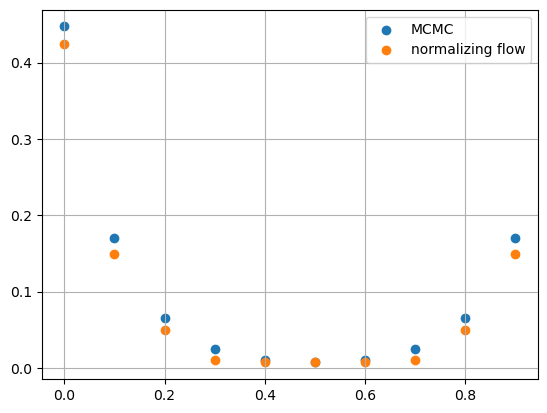

In [25]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G

"""
ens_nf=ensemble.ensemble.load("nf_ensemble.txt",basic_oscillator)
g_nf=np.vstack(ensemble.ensemble.Vaverage_and_sigma(ens_nf,G))
g_nf=g_nf.transpose()[0]
"""

g=g_osc
print(len(g))
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)
plt.scatter(MCMC_list,g)
plt.scatter(NF_list,g_nf)
plt.legend(["MCMC","normalizing flow"])
plt.grid(True)
plt.show()

In [55]:
L_layer=L(N_nod)
L_layer.load_state_dict(torch.load("L_layer_weights.pth"))
print(L_layer.adj(A))

tensor([[ 9.7450e-01,  6.8725e-03,  1.6029e-03,  ...,  2.9996e-02,
          1.2987e-02, -1.0077e-02],
        [ 6.8728e-03,  1.0180e+00, -1.9002e-02,  ...,  4.0149e-04,
         -1.8119e-02,  1.3663e-03],
        [ 1.6030e-03, -1.9002e-02,  9.8187e-01,  ...,  1.0302e-02,
         -7.3258e-03,  9.5749e-03],
        ...,
        [ 2.9996e-02,  4.0149e-04,  1.0302e-02,  ...,  9.7388e-01,
         -4.3421e-03, -1.0112e-02],
        [ 1.2987e-02, -1.8119e-02, -7.3258e-03,  ..., -4.3421e-03,
          1.0155e+00, -2.4950e-02],
        [-1.0077e-02,  1.3663e-03,  9.5749e-03,  ..., -1.0112e-02,
         -2.4950e-02,  1.0105e+00]], grad_fn=<MmBackward0>)


In [54]:
C=(torch.tensor(get_C(N_nod,beta)).float()).to(device)
Ct=torch.t(C)
A_e=torch.matmul(Ct,torch.matmul(A,C))
print(A_e)
A_D=torch.matmul(Ot,torch.matmul(A,O))
print(A_D)
print(torch.linalg.matrix_norm(A_e-I))

tensor([[ 1.0000e+00,  5.8752e-08, -1.3914e-08,  ...,  2.2872e-08,
          2.5498e-07,  0.0000e+00],
        [ 4.0992e-08,  1.0000e+00, -2.7618e-08,  ...,  2.2800e-08,
         -2.4269e-08,  2.8902e-08],
        [-5.8108e-10, -9.3866e-08,  1.0000e+00,  ...,  4.4837e-09,
         -4.7684e-07, -5.5179e-08],
        ...,
        [-1.2623e-09,  5.3057e-09, -3.6523e-10,  ...,  1.0000e+00,
         -3.5937e-09,  1.9324e-08],
        [-7.7986e-10, -1.9018e-10,  1.1782e-10,  ...,  5.4074e-10,
          1.0000e+00, -2.6425e-09],
        [ 7.4506e-09, -1.3039e-08, -2.9977e-09,  ..., -1.6764e-08,
         -5.8208e-09,  1.0000e+00]])
tensor([[ 2.0000e-01, -7.7642e-09, -1.9571e-09,  ..., -1.1199e-07,
         -3.6891e-07,  0.0000e+00],
        [-6.7893e-10,  2.7885e-01, -2.3201e-08,  ...,  2.8581e-08,
          3.0639e-09,  3.8130e-08],
        [-4.9183e-10, -5.3233e-09,  2.7885e-01,  ..., -8.5684e-10,
         -9.5367e-07, -5.2030e-07],
        ...,
        [ 3.9386e-09, -8.6246e-11, -2.1778e-09